## Data Visualisation

## Objectives

- Fulfill Business requirement 1 - to differentiate between infected and non-infected cherry leaves.

## Inputs

- inputs/cherry_leaves_raw_dataset/cherry-leaves/train
- inputs/cherry_leaves_raw_dataset/cherry-leaves/validation
- inputs/cherry_leaves_raw_dataset/cherry-leaves/test

## Outputs

- 

## Install dependencies

In [19]:
pip install -r ./requirements.txt

  Using cached numpy-1.19.2-cp38-cp38-manylinux2010_x86_64.whl (14.5 MB)
  Using cached pandas-1.1.2-cp38-cp38-manylinux1_x86_64.whl (10.4 MB)
  Using cached matplotlib-3.3.1-cp38-cp38-manylinux1_x86_64.whl (11.6 MB)
  Using cached seaborn-0.11.0-py3-none-any.whl (283 kB)
  Using cached plotly-4.12.0-py2.py3-none-any.whl (13.1 MB)
  Using cached streamlit-0.85.0-py2.py3-none-any.whl (7.9 MB)
  Using cached scikit_learn-0.24.2-cp38-cp38-manylinux2010_x86_64.whl (24.9 MB)
  Using cached tensorflow_cpu-2.6.0-cp38-cp38-manylinux2010_x86_64.whl (172.4 MB)
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
  Using cached protobuf-3.20.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Using cached altair-4.2.2-py3-none-any.whl (813 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached certifi-2024.2.2-py3-none-any.whl (163 kB)
  Using cach


## Change working directory

Change working directory from current to parent folder.

In [20]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

In [21]:
os.chdir("/workspace/mildew-detection")
print("You set a new current directory.")

You set a new current directory.


In [22]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

## Set input directories

In [23]:
data_dir = "inputs/cherry_leaves_raw_dataset/cherry-leaves"
train_dir = data_dir + "/train"
val_dir = data_dir + "/validation"
test_dir = data_dir + "/test"

## Set output directories

In [24]:
version = "v1"
file_path = f"outputs/{version}"
if "outputs" in os.listdir(current_dir) and version in os.listdir(current_dir + "/outputs"):
    print("This directory already exists, please create a new version.")
else:
    os.makedirs(name=file_path)

This directory already exists, please create a new version.


## Set label names

In [25]:
labels = os.listdir(train_dir)
print("The image labels are ", labels)

The image labels are  ['healthy', 'powdery_mildew']


## Import libraries

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Image shape

Plot image height and width

In [ ]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_dir + '/' + label):
        img = imread(train_dir + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)
        dim2.append(d2)

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Image width (pixels)")
axes.set_ylabel("Image height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Average image width: {dim2_mean} \nAverage image height: {dim1_mean}")

### Save image shape

In [34]:
image_shape = dim2_mean, dim1_mean, 3
if "image_shape.pkl" not in file_path:
    joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

## Data visualisation

Resize images and load image shapes and labels in an array

In [49]:
from tensorflow.keras.preprocessing import image

# Function to 
def load_img_array(data_dir, resized=(80,80), n_img_per_label=30):
    X, y = np.array([], dtype="int"), np.array([], dtype="object")
    labels = os.listdir(data_dir)

    for label in labels:
        count = 0
        for img_file in os.listdir(data_dir + "/" + label):
            if count < n_img_per_label:
                file = image.load_img(data_dir + "/" + label + "/" + img_file, color_mode="rgb", target_size = resized)
                if image.img_to_array(file).max() > 1:
                    resize_img = image.img_to_array(file) /255
                else:
                    resize_img = mage.img_to_array(file)
                X = np.append(X, resize_img).reshape(-1, resized[0], resized[1], resize_img.shape[2])
                y = np.append(y, label)
                count += 1
    
    return X, y

In [50]:
X, y = load_img_array(data_dir=train_dir, 
                resized=image_shape, 
                n_img_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


## Display average image by label type, show difference between them

In [54]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Calculate the difference between average images of two labels and optionally save the result as an image.

    Parameters:
    - X: Input array of images.
    - y: Labels corresponding to the images.
    - label_1: First label for comparison.
    - label_2: Second label for comparison.
    - figsize: Tuple specifying the figure size (width, height).
    - save_image: Boolean to indicate whether to save the difference image.

    Returns:
    None
    """    
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label_1} or label {label_2} are not in {np.unique(y)}")
        return

    # Calculate mean image from label_1
    images_label_1 = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label_1, axis=0)

    # Calculate mean image from label_2
    images_label_2 = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label_2, axis=0)

    # Calculate and plot the difference, average label_1 (infected with mildew), and average label_2 (uninfected)
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1}, {label_2}')

    if save_image:
        plt.savefig(f"avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


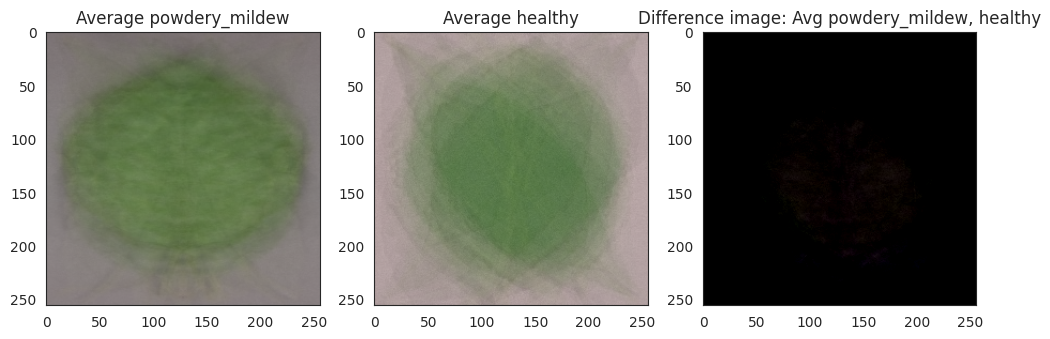

In [55]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='powdery_mildew', label_2='healthy',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

## Image montage

Create a function to display a montage of images from each label.

In [ ]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

Run the image montage for both labels.

healthy


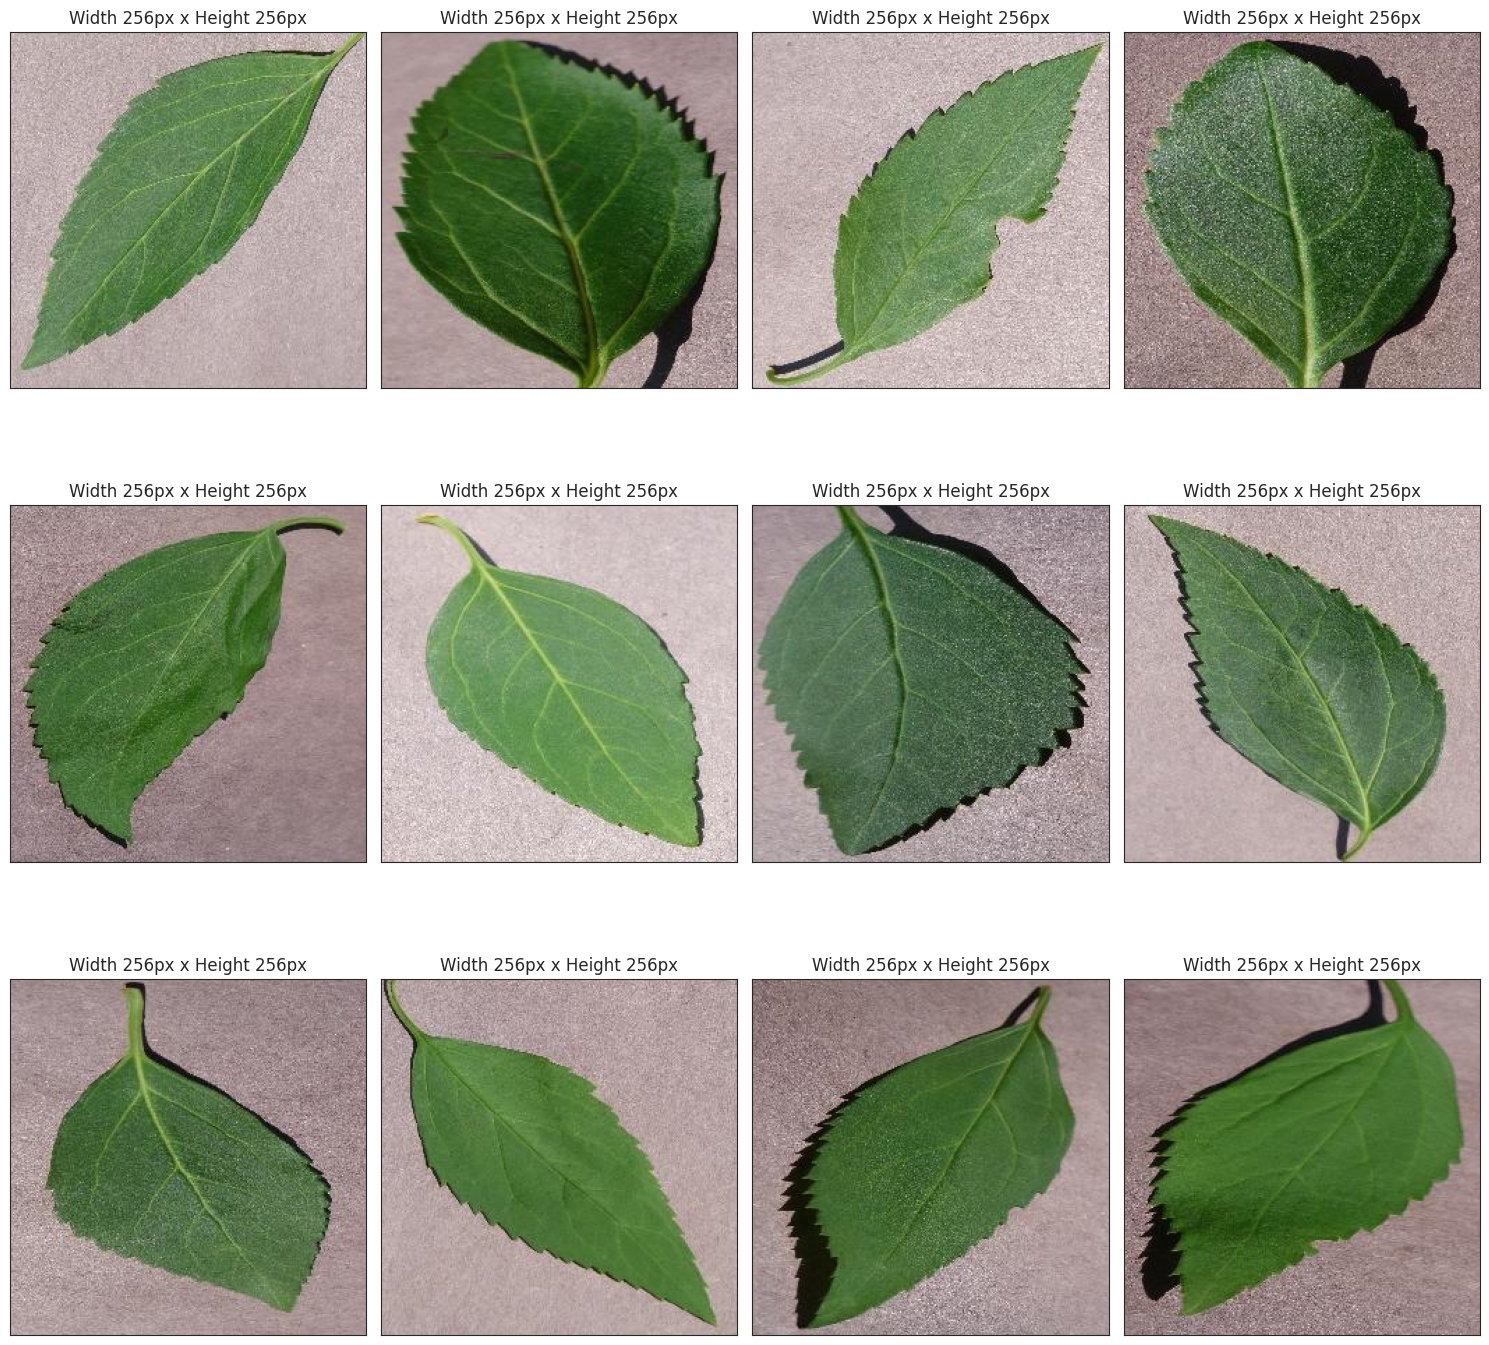

powdery_mildew


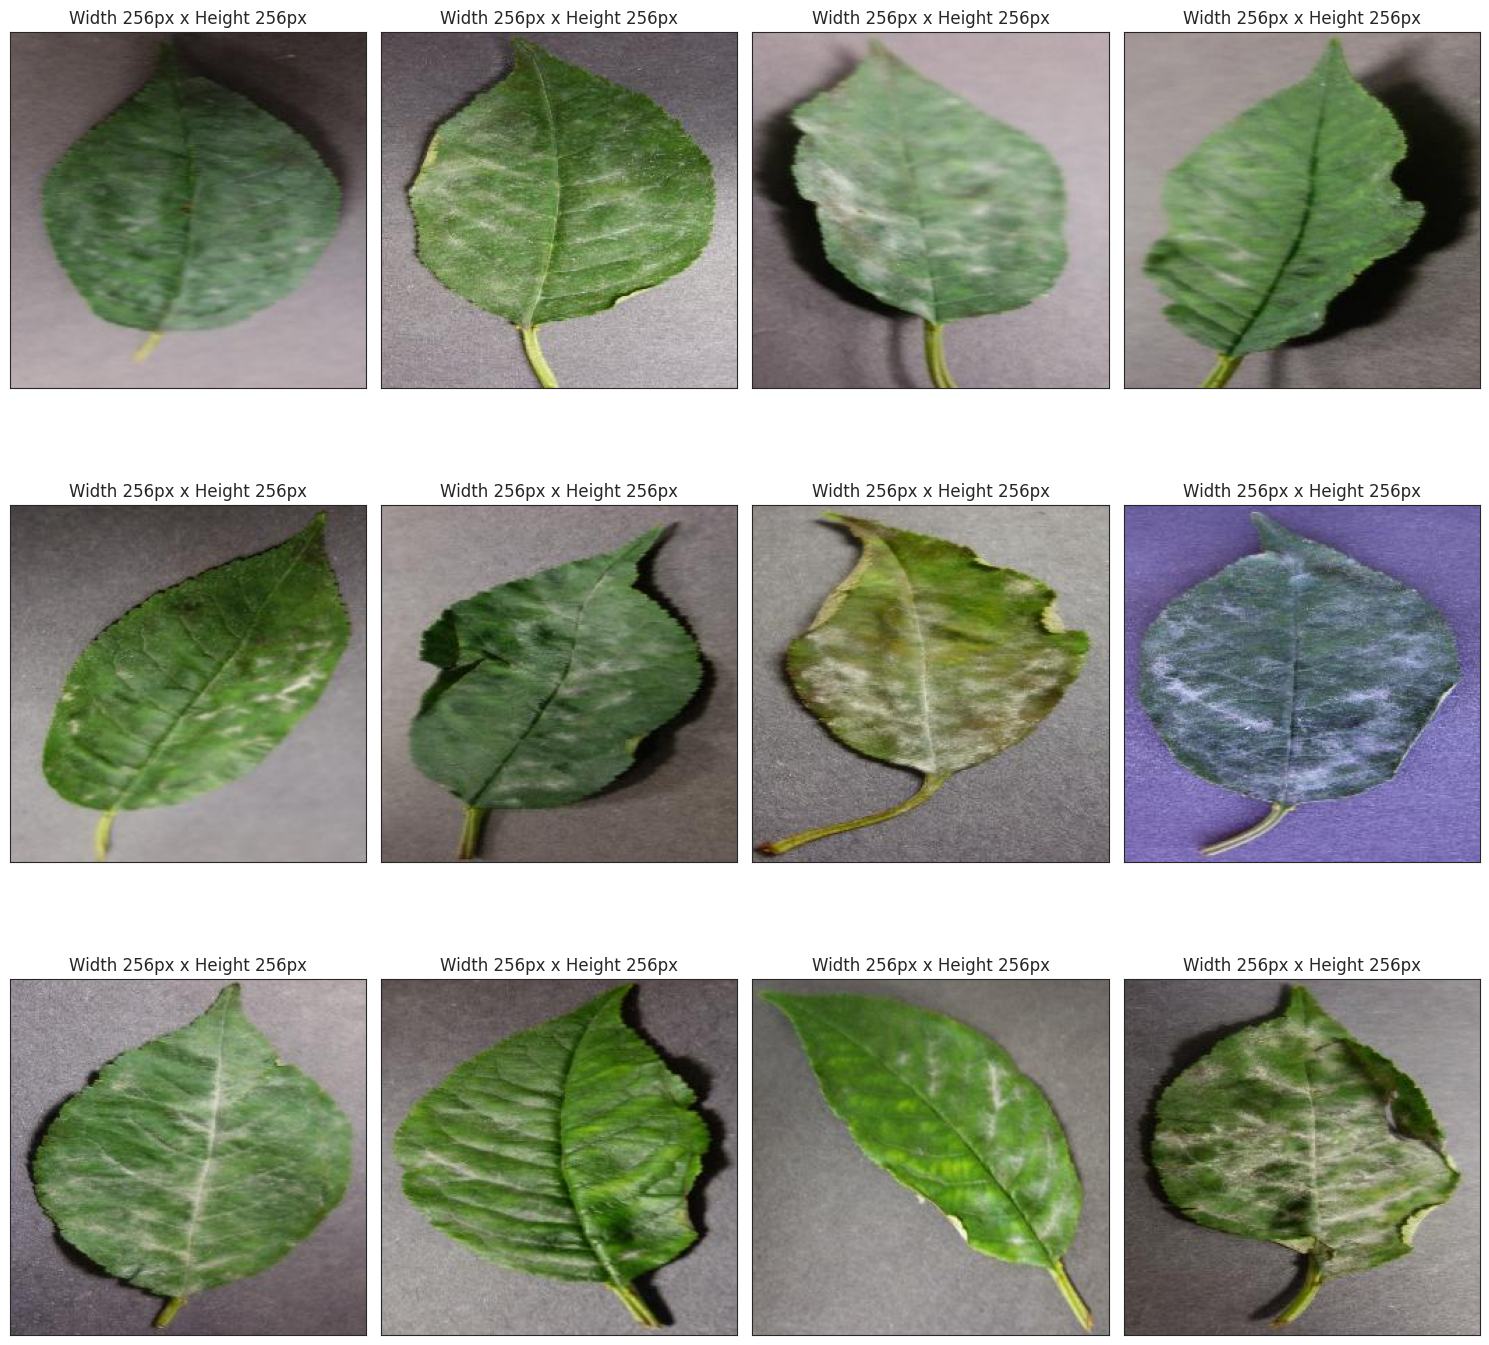

In [63]:
for label in labels:
    print(label)
    image_montage(dir_path=train_dir,
                  label_to_display=label,
                  nrows=3, ncols=4,
                  figsize=(15, 15)
                  )
    